# Interpreting Language Models with Contrastive Explanations
### ___Kayo Yin and Graham Neubig___
This Colab notebook lets you visualize contrastive explanations for language model decisions, based on [Yin and Neubig (2022)](https://arxiv.org/abs/2202.10419).





In [1]:
#@markdown #**Setup Environment**
#@markdown Install and import Python dependencies.
print('Importing libraries...')
from IPython.display import clear_output
import sys
sys.path.append('./interpret-lm')
from lm_saliency import *
from sklearn.cluster import KMeans
import numpy as np
import random
import hashlib
import re
import sys
import tarfile
from collections import Counter, defaultdict
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import requests
# import nltk
# from nltk.tokenize import word_tokenize
# nltk.download('all')
clear_output()
print('Done!')

if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

Done!


In [2]:
if not torch.cuda.is_available():
  print("Please restart runtime with GPU")

In [3]:
 #@markdown #**Open pre-made vocab**
  #@markdown Open pre-made vocab made from wikitext-103. The vocab is tokenized and tagged using nltk. It is done beforehand because of memory issues.
with open('/home/scur0635/Baseline_clusters/vocab_tagged.json', 'r') as f:
  vocab_tagged = json.load(f)

In [4]:
 #@markdown #**Open pre-made sentence list**
 #@markdown Open pre-made sentence list made from wikitext-103. It is done using regex which is a slow process so done beforehand.
with open('/home/scur0635/Baseline_clusters/sentences_standard.json', 'r') as f:
  sentences_list = json.load(f)

In [5]:
Small_sample = "Can you stop the dog from"

In [6]:
 #@markdown #**Only take f.i. verbs from the vocab**
# verbs = [item for item in vocab_tagged if item[0][1] in ['VBD', 'VB']]

# Sort verbs based on frequency in descending order
# sorted_verbs = sorted(verbs, key=lambda x: x[1], reverse=True)

sorted_words = sorted(vocab_tagged, key=lambda x: x[1], reverse=True)
sorted_words = [x for x in sorted_words if not re.findall('[^ a-zA-Z0-9]|unk',x[0][0])]
# Print the sorted verbs
top_words = sorted_words[:10000]
top_words = [x[0][0] for x in top_words]

In [7]:
y_t ="barking" #@param ["go", "he" , "man", "black"]
targets = [y_t]

In [14]:
 #@markdown #**Sample set X**
sample_size = 100 #@param [100, 200, 300, 400, 500]
target_list = [x for x in sentences_list for trgt in [" "+y_t+" ", " "+y_t+","," "+y_t+"."," "+y_t+"?"," "+y_t+"!"] if trgt in x]
samples = random.sample(target_list, sample_size)
samples = [x.split(y_t)[0] for x in samples if re.search(r'.+ .+ '+y_t, x)]

In [8]:
#@markdown #**Load Language Model**
model_name = "gpt-2" #@param ["gpt-2", "gpt-neo"]

if model_name == "gpt-2":
  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
  model = GPT2LMHeadModel.from_pretrained("gpt2")
  vocab = list(tokenizer.encoder.keys())
elif model_name == "gpt-neo":
  model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
  tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == "cuda"
model.to(device)
clear_output()

In [9]:
#@markdown #**Retrieve contrastive explanation function**
def expl_vec(target, foil, input, explanation):

  input = input.strip() + " "
  input_tokens = tokenizer(input)['input_ids']
  attention_ids = tokenizer(input)['attention_mask']
  CORRECT_ID = tokenizer(" "+ target)['input_ids'][0]
  FOIL_ID = tokenizer(" "+ foil)['input_ids'][0]


  if explanation == "erasure":
    contra_explanation = erasure_scores(model, input_tokens, attention_ids, correct=CORRECT_ID, foil=FOIL_ID, normalize=True)
  else:
    saliency_matrix, embd_matrix = saliency(model, input_tokens, attention_ids, foil=FOIL_ID)
    if explanation == "input x gradient":
      contra_explanation = input_x_gradient(saliency_matrix, embd_matrix, normalize=False)
    elif explanation == "gradient norm":
      contra_explanation = l1_grad_norm(saliency_matrix, normalize=True)
  return contra_explanation

In [10]:
results = []
for target in targets:
  for foil in top_words:
    e_y_t = expl_vec(target, foil, Small_sample, "input x gradient")
    results.append(e_y_t)

/home/scur0635/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [17]:
#@markdown #**Loop over targets, foils and samples**
# results = []
# for target in targets:
#   for foil in top_words:
#     vec_list = []
#     for input in samples:
#       e_x_y_t = expl_vec(target, foil, input, "input x gradient")
#       vec_list.append(e_x_y_t)
#     e_y_t = np.concatenate(vec_list)
#     results.append(e_y_t)

In [22]:
with open('/home/scur0635/Baseline_clusters/verb_results.npy', 'wb') as f:
    np.save(f, results)

In [ ]:
from google.colab import files
files.download('verb_results.npy')

In [23]:
with open('/home/scur0635/Baseline_clusters/verb_results.npy', 'rb') as f:
    testiebestie = np.load(f)

In [29]:
#@markdown #**Fit KMeans cluster**
#@markdown Fit KMeans cluster on what I think are 3 clusters? Those are the catogaries they use in the paper from what I understand.
kmeans = KMeans()
kmeans.fit(results)

/home/scur0635/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1551e30d3c10>
Traceback (most recent call last):
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x1551e30d3dc0>
Traceback (most recent call last):
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/sw/arch/Centos8/EB_production/2021/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_conf

KMeans()

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# model = AgglomerativeClustering(linkage="ward", n_clusters=2)
# model.fit(results)

In [12]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [13]:
# X = np.array(results)
# # distance, weight = get_distances(X,model)
# # linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)
# plt.figure(figsize=(100,200))
# linkage_matrix = linkage(X, 'ward')
# dendrogram(linkage_matrix, orientation="right")
# plt.show()

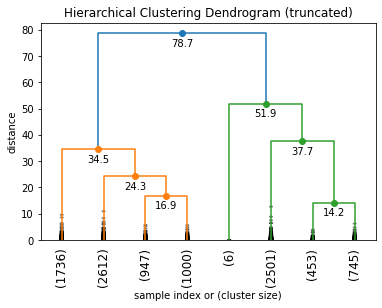

In [14]:
X = np.array(results)
linkage_matrix = linkage(X, 'ward')

fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=8,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [69]:
clusters = fcluster(linkage_matrix, t = 35, criterion='distance')

In [70]:
def map_words_to_clusters(words, indices):
    word_clusters = {}

    for word, cluster_index in zip(words, indices):
        if cluster_index not in word_clusters:
            word_clusters[cluster_index] = [word]
        else:
            word_clusters[cluster_index].append(word)

    return word_clusters

In [71]:
clusters_words = map_words_to_clusters(top_words, clusters)
clusters_words = dict(sorted(clusters_words.items()))
for cluster_index, cluster_words in clusters_words.items():
    print(f"Cluster {cluster_index}: {len(cluster_words)} :{cluster_words[:10]}")

Cluster 1: 6295 :['000', 'song', 'album', 'united', 'episode', 'american', 'released', 'century', 'north', 'march']
Cluster 2: 6 :['ian', 'ernest', 'ivan', 'ix', 'iphone', 'vernon']
Cluster 3: 2501 :['during', 'game', 'than', 'film', 'later', 'season', 'however', 'then', 'series', 'city']
Cluster 4: 1198 :['the', 'of', 'and', 'in', 'to', 'a', 'was', 'on', 'for', 'as']


In [72]:
def take_mean_vec(top_words, results, cluster_index):
    listie = []
    for i in zip(top_words, results):
        if i[0] in clusters_words[cluster_index]:
            listie.append(np.array(i[1]))
    mean_vectors = np.mean(listie, axis=0)
    return mean_vectors

In [73]:
for cluster_index, _ in clusters_words.items():
    print(f"Cluster {cluster_index}: Mean_Vec {take_mean_vec(top_words, results, cluster_index)}")

Cluster 1: Mean_Vec [-0.08336119 -0.41663527  0.15744907 -1.0076028  -0.12646203 -0.7196826 ]
Cluster 2: Mean_Vec [ 6.8884053  -2.5498006  -1.6961079   3.2297966  -0.16884333 12.448869  ]
Cluster 3: Mean_Vec [-0.05599599 -0.09981599  0.08690602 -0.48707607 -0.0680013  -0.1569498 ]
Cluster 4: Mean_Vec [-0.06127366  0.29170072  0.04377401  0.13252021 -0.02687191  0.4223877 ]


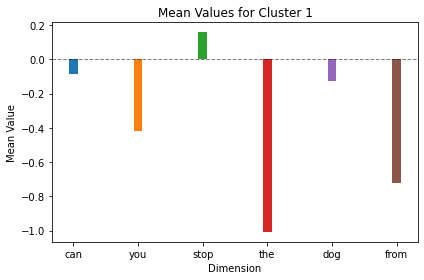

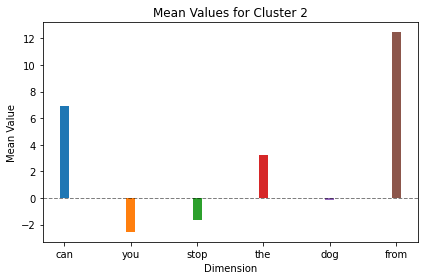

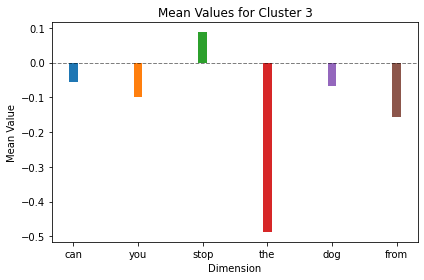

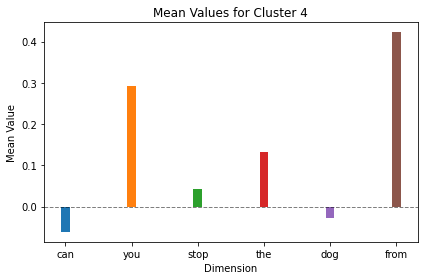

In [80]:
#Cluster means
cluster_means = [take_mean_vec(top_words, results, x) for x in clusters_words.keys()]

# Number of clusters
num_clusters = len(cluster_means)

# Number of bars in each cluster (dimension of the vectors)
num_bars = len(cluster_means[0])

# Bar width for better visualization
bar_width = 0.8 / num_bars  # Adjusted bar width for better visualization

# Set up colors for each cluster
colors = plt.cm.tab10(np.arange(num_bars))

# Create individual subplots for each cluster
for i in range(num_clusters):
    fig, ax = plt.subplots()
    ax.bar(np.arange(num_bars), cluster_means[i], width=bar_width, color=colors)
    
    # Add labels and title
    ax.set_xlabel(f'Dimension')
    ax.set_ylabel(f'Mean Value')
    ax.set_title(f'Mean Values for Cluster {i+1}')
    ax.set_xticks(range(num_bars))
    ax.set_xticklabels(['can', 'you', 'stop', 'the', 'dog', 'from'])

    # Add a horizontal line at y=0 for better visualization
    ax.axhline(y=0, color='black', linewidth=1, linestyle='--', alpha=0.5)

    # Show the plot
    plt.savefig(f'Cluster_means_{i+1}.pdf')
    plt.tight_layout()
    plt.show()
    

In [39]:
# #@markdown #**Function for finding indexes of a certain cluster**
# def ClusterIndicesNumpy(clustNum, labels_array): #numpy
#     return np.where(labels_array == clustNum)[0]

In [19]:
# #@markdown #**Function for retrieving words from indexes**
# def retrieve_words(cluster, words, kmeans):
#   idx = ClusterIndicesNumpy(cluster, kmeans.labels_)
#   results = []
#   for word in words:
#     if words.index(word) in idx:
#       results.append(word)
#   return results

In [20]:
# Foil_cluster = retrieve_words(7, top_words, kmeans)
# print(Foil_cluster)

In [21]:
# for i in range(8):
#   cluster = retrieve_words(i, top_words, kmeans)
#   print('Cluster',i)
#   print('------------------------------')
#   print(cluster[:10])
#   print('------------------------------')